In [1]:
import pandas as pd

In [2]:
import cortex

In [3]:
import glob

In [4]:
import re
reg = re.compile('.*/sub-(?P<subject>.+)/ses-(?P<session>.+)/func/sub-(.+)_ses-.+_hemi-(?P<hemi>lh|rh)_energies\.pkl')

In [5]:
fns = glob.glob('/data/odc/derivatives/zmap_spatfreq/sub-*/ses-*/func/sub-*_ses-*_hemi-*_energies.pkl')

In [6]:
def get_vertex_mask(subject, hemi='lh', roi='V1'):
    
    
    if hemi == 'lh':
        mask = cortex.utils.get_roi_verts('odc.{}'.format(subject), roi=roi+'l')[roi+hemi[:1]]
    elif hemi == 'rh':
        left_pts, _ = cortex.db.get_surf('odc.{}'.format(subject), hemisphere='left', type='fiducial')
        mask = cortex.utils.get_roi_verts('odc.{}'.format(subject), roi=roi+'r')[roi+hemi[:1]]
        mask -= len(left_pts)
        
    return mask

In [7]:
energies = []
idx = []

for fn in fns:
    e = pd.read_pickle(fn)
    e = e.loc[:,~e.isnull().any(0)]

    meta = reg.match(fn).groupdict()    
    mask = get_vertex_mask(meta['subject'], meta['hemi'])
    
    ix = e.columns.intersection(mask)
    
    e = e.loc[:, ix]    
    print('{}/{} V1 vertices have energy ({}, {})'.format(len(ix), len(mask), meta['subject'], meta['session'], meta['hemi']))
    
    idx.append(meta)
    
    energies.append(e)
    
# energies = pd.concat(energies, axis=0)

3072/6597 V1 vertices have energy (bm, odc)
2179/4628 V1 vertices have energy (bm, odc)
5320/11046 V1 vertices have energy (de, odc1)
3025/9886 V1 vertices have energy (de, odc1)
3553/9503 V1 vertices have energy (eo, odc)
4863/8879 V1 vertices have energy (eo, odc)
3170/7012 V1 vertices have energy (ms, odc2)
2880/6888 V1 vertices have energy (ms, odc2)
5004/9560 V1 vertices have energy (ns, odc)
2736/9847 V1 vertices have energy (ns, odc)
2740/5771 V1 vertices have energy (tk, odc2)
3347/6746 V1 vertices have energy (tk, odc2)
2682/5771 V1 vertices have energy (tk, odc3)
2992/6746 V1 vertices have energy (tk, odc3)
4455/9629 V1 vertices have energy (tr, odc)
5571/10898 V1 vertices have energy (tr, odc)


In [8]:
energies = pd.concat(energies, 
                     keys=[(d['subject'], d['session'], d['hemi']) for d in idx], 
                     names=['subject', 'session', 'hemi', 'vertex'],
                     axis=1)

In [9]:
energies_incl_outliers = energies.copy()

In [10]:
energies = energies.drop([('bm', 'odc', 'lh'), ('ns')], axis=1)

In [11]:
max_frequency = energies.groupby(['depth', 'frequency']).sum().groupby('depth', as_index=True).apply(lambda d: d.reset_index('depth', drop=True).idxmax())

In [12]:
max_wl = 1. / max_frequency

In [13]:
import seaborn as sns

In [14]:
import numpy as np

In [15]:
import matplotlib.pyplot as plt

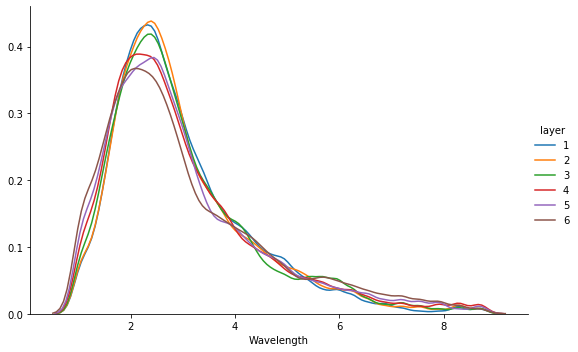

In [16]:
tmp = max_wl.copy()
ix = max_wl.index.tolist()
tmp.index = pd.Index([6 - ix.index(i) for i in ix], name='layer')
tmp = tmp.reset_index().melt(id_vars=tmp.index.names, value_name='Wavelength')
fac = sns.FacetGrid(tmp[tmp.Wavelength < 9], hue='layer', aspect=1.5, height=5)
fac.map(sns.distplot, 'Wavelength', hist=False)
fac.add_legend()

plt.savefig('/data/odc/figures/sf_histogram.pdf', transparent=True)

In [18]:
mean_wl_energie_across_orientations = energies.groupby(['depth', 'frequency']).mean()

mean_wl_energie_across_orientations.T.groupby(['subject', 'session', 'hemi']).mean()

depth                    0.143                                          \
frequency             0.100000  0.104811  0.109854  0.115140  0.120679   
subject session hemi                                                     
bm      odc     rh    0.115038  0.118465  0.121990  0.125378  0.128328   
de      odc1    lh    0.100633  0.102659  0.104744  0.106843  0.108967   
                rh    0.099394  0.099764  0.099932  0.099873  0.099641   
eo      odc     lh    0.096893  0.099958  0.103047  0.105929  0.108338   
                rh    0.119113  0.119797  0.120049  0.120145  0.120572   
ms      odc2    lh    0.064073  0.065883  0.067655  0.069238  0.070548   
                rh    0.063733  0.067198  0.070490  0.073461  0.076096   
tk      odc2    lh    0.072072  0.076021  0.080222  0.084526  0.088881   
                rh    0.086148  0.089373  0.093170  0.097344  0.101730   
        odc3    lh    0.093264  0.095187  0.098365  0.102154  0.105810   
                rh    0.101428  0.101345  0.102177  0.103773  0.105816   
tr      odc     lh    0.093027  0.095383  0.098169  0.101383  0.105022   
                rh    0.094771  0.096287  0.097801  0.099294  0.100851   

depth                                                                   ...  \
frequency             0.126486  0.132571  0.138950  0.145635  0.152642  ...   
subject session hemi                                                    ...   
bm      odc     rh    0.130807  0.132791  0.134418  0.136005  0.138031  ...   
de      odc1    lh    0.111150  0.113388  0.115622  0.117754  0.119633  ...   
                rh    0.099383  0.099191  0.099118  0.099342  0.099923  ...   
eo      odc     lh    0.110058  0.111157  0.111766  0.112070  0.112273  ...   
                rh    0.121749  0.123546  0.125700  0.128033  0.130499  ...   
ms      odc2    lh    0.071699  0.072709  0.073820  0.075227  0.077039  ...   
                rh    0.078469  0.080682  0.082822  0.084846  0.086763  ...   
tk      odc2    lh    0.093202  0.097234  0.100826  0.103755  0.106036  ...   
                rh    0.105916  0.109890  0.113554  0.117004  0.120306  ...   
        odc3    lh    0.108941  0.111273  0.112803  0.113727  0.114345  ...   
                rh    0.108017  0.110129  0.112062  0.113823  0.115438  ...   
tr      odc     lh    0.109094  0.113398  0.117835  0.122188  0.126358  ...   
                rh    0.102472  0.104158  0.105902  0.107739  0.109749  ...   

depth                    0.857                                          \
frequency             0.655129  0.686649  0.719686  0.754312  0.790604   
subject session hemi                                                     
bm      odc     rh    0.179149  0.172289  0.165428  0.158874  0.152715   
de      odc1    lh    0.110689  0.107574  0.104345  0.101103  0.097866   
                rh    0.107917  0.105283  0.102525  0.099689  0.096809   
eo      odc     lh    0.101219  0.098109  0.094964  0.091852  0.088762   
                rh    0.104768  0.101678  0.098540  0.095460  0.092441   
ms      odc2    lh    0.100377  0.097421  0.094435  0.091490  0.088589   
                rh    0.102930  0.099941  0.096879  0.093797  0.090712   
tk      odc2    lh    0.115989  0.111733  0.107442  0.103244  0.099186   
                rh    0.111703  0.108032  0.104299  0.100631  0.097039   
        odc3    lh    0.119623  0.115234  0.110811  0.106493  0.102315   
                rh    0.117320  0.113170  0.109034  0.105049  0.101230   
tr      odc     lh    0.134385  0.129393  0.124606  0.120131  0.115921   
                rh    0.122857  0.119307  0.115706  0.112125  0.108541   

depth                                                                   
frequency             0.828643  0.868511  0.910298  0.954095  1.000000  
subject session hemi                                                    
bm      odc     rh    0.146991  0.141702  0.136702  0.131975  0.127507  
de      odc1    lh    0.094670  0.091542  0.088469  0.085479  0.082583  


In [51]:
mean_wl_energie_across_orientations.mean(1).unstack()

frequency,0.10000000000000037,0.10481131341546897,0.10985411419875622,0.11513953993264514,0.1206792640639333,0.12648552168553004,0.13257113655901134,0.13894954943731422,0.14563484775012484,0.15264179671752381,...,0.6551285568595513,0.6866488450043006,0.7196856730011524,0.7543120063354622,0.7906043210907702,0.8286427728546847,0.8685113737513528,0.9102981779915221,0.954095476349994,1.0
depth,,,,,,,,,,,,,,,,,,,,,
0.143,0.093608,0.095634,0.097828,0.100094,0.102378,0.104656,0.106865,0.108982,0.111016,0.113019,...,0.130025,0.126784,0.123420,0.120020,0.116587,0.113141,0.109693,0.106199,0.102714,0.099272
0.286,0.094142,0.095995,0.098027,0.100169,0.102328,0.104444,0.106487,0.108468,0.110453,0.112505,...,0.132369,0.128820,0.125162,0.121493,0.117824,0.114180,0.110566,0.106937,0.103342,0.099807
0.429,0.093795,0.095368,0.097088,0.098881,0.100712,0.102591,0.104522,0.106511,0.108588,0.110778,...,0.131510,0.127760,0.123899,0.120034,0.116187,0.112390,0.108672,0.104970,0.101343,0.097807
0.571,0.089567,0.090821,0.092190,0.093680,0.095327,0.097149,0.099146,0.101313,0.103633,0.106055,...,0.128096,0.124237,0.120281,0.116335,0.112429,0.108598,0.104872,0.101198,0.097635,0.094194
0.714,0.085870,0.086997,0.088171,0.089459,0.090939,0.092671,0.094688,0.096975,0.099480,0.102117,...,0.124316,0.120306,0.116243,0.112242,0.108326,0.104525,0.100857,0.097253,0.093763,0.090395
0.857,0.083392,0.084198,0.085067,0.086087,0.087363,0.088977,0.090942,0.093249,0.095836,0.098596,...,0.116213,0.112500,0.108757,0.105090,0.101507,0.098034,0.094680,0.091392,0.088207,0.085131


In [77]:
np.geomspace(10, 1, 6)

array([10.        ,  6.30957344,  3.98107171,  2.51188643,  1.58489319,
        1.        ])

In [92]:
mode_frequency_per_vertex = energies.groupby(['depth', 'frequency']).sum().groupby(['depth'], as_index=True).apply(lambda d: d.reset_index('depth', drop=True).idxmax(0))

In [94]:
wl = mode_frequency_per_vertex.T.stack('depth').to_frame('main frequency').groupby(['subject', 'session', 'hemi', 'depth']).median()
wl['wavelength'] = 1./wl['main frequency']

In [96]:
wl.groupby('depth').mean()

,main frequency,wavelength
depth,,
0.143,0.379661,2.654932
0.286,0.376404,2.690773
0.429,0.370960,2.750622
0.571,0.374249,2.693886
0.714,0.370638,2.726753
0.857,0.369788,2.740679


In [124]:
((map_.columns - 1./cycle)**2).argmin()

49

In [277]:
sns.set(font='helvetica', style='white', font_scale=2.)

In [278]:
tmp = mean_wl_energie_across_orientations.T.groupby(['subject', 'session'], axis=0).mean()
sem = tmp.std(1) / len(tmp)

In [279]:
sem = wl.groupby(['subject', 'session']).mean().std()['wavelength'] / 6

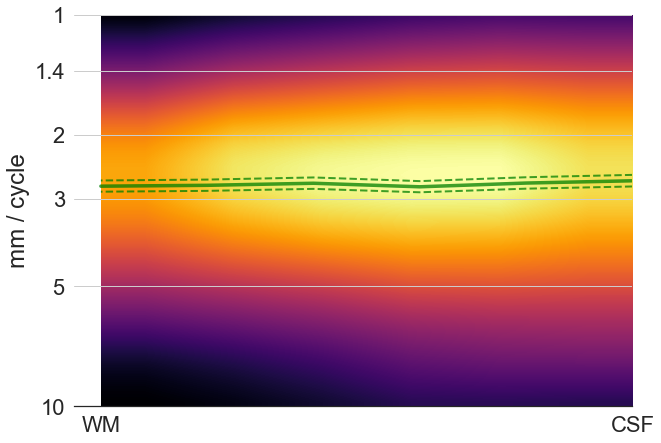

In [339]:
map_ = mean_wl_energie_across_orientations.mean(1).unstack()
plt.imshow(np.fliplr(map_.values.T), 
           origin='lower',
           aspect=1.6, cmap='inferno', interpolation='bilinear',
           extent=[5, 0, np.log(10), np.log(1)])


plt.xticks([0., 5.
           ], ['CSF', 'WM'],)
plt.xlim(5.25, 0.)

mean_wl = wl.groupby('depth').mean()['wavelength']

plt.plot(range(6), np.log(mean_wl),c='green',  alpha=.75, ls='-', lw=3.5)
plt.plot(range(6), np.log(mean_wl + 1.96 * sem),c='green',  alpha=.75, ls='--', lw=2.)
plt.plot(range(6), np.log(mean_wl - 1.96 * sem),c='green',  alpha=.75, ls='--', lw=2.)

ixs = []
cycles = [10, 5, 3, 2, 1.4, 1]
for cycle in cycles:
    ix = 1./map_.columns[((map_.columns - 1./cycle)**2).argmin()]
    ix = np.log(ix)
    ixs.append(ix)
    
plt.yticks(ixs, ['{}'.format(c) for c in cycles], rotation='horizontal')
plt.grid(True, axis='y')
plt.ylabel('mm / cycle')
sns.despine(left=True, right=True)
plt.gcf().set_size_inches(10, 10)
plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/known_patterns/spatial_frequency_distribution.svg', transparent=True)

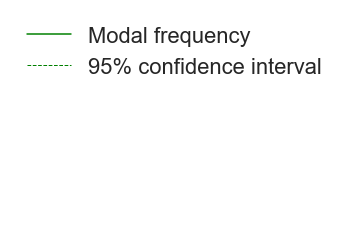

In [337]:
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], color='green', lw=1.5),
                Line2D([0], [0], color='green', lw=1., ls='--'),]

leg = plt.legend(custom_lines, ['Modal frequency', '95% confidence interval'])
leg.get_frame().set_linewidth(0.0)

plt.axis('off')
plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/known_patterns/depth_power_legend.pdf', transparent=True)

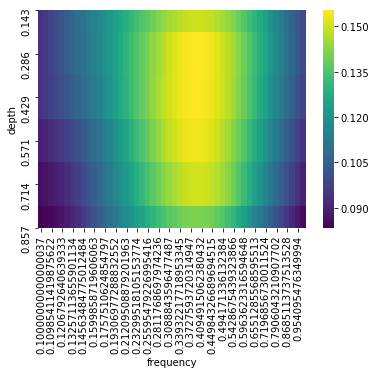

In [53]:
sns.heatmap(mean_wl_energie_across_orientations.mean(1).unstack(), cmap='viridis')

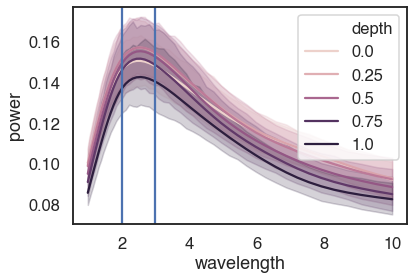

In [284]:
power = mean_wl_energie_across_orientations.T.groupby(['subject', 'session', 'hemi']).mean().stack(['depth', 'frequency'])
power = power.to_frame('power').reset_index()
power['wavelength'] = 1./power['frequency']
sns.lineplot('wavelength', 'power', 'depth', data=power)
plt.axvline(2.)
plt.axvline(3.)

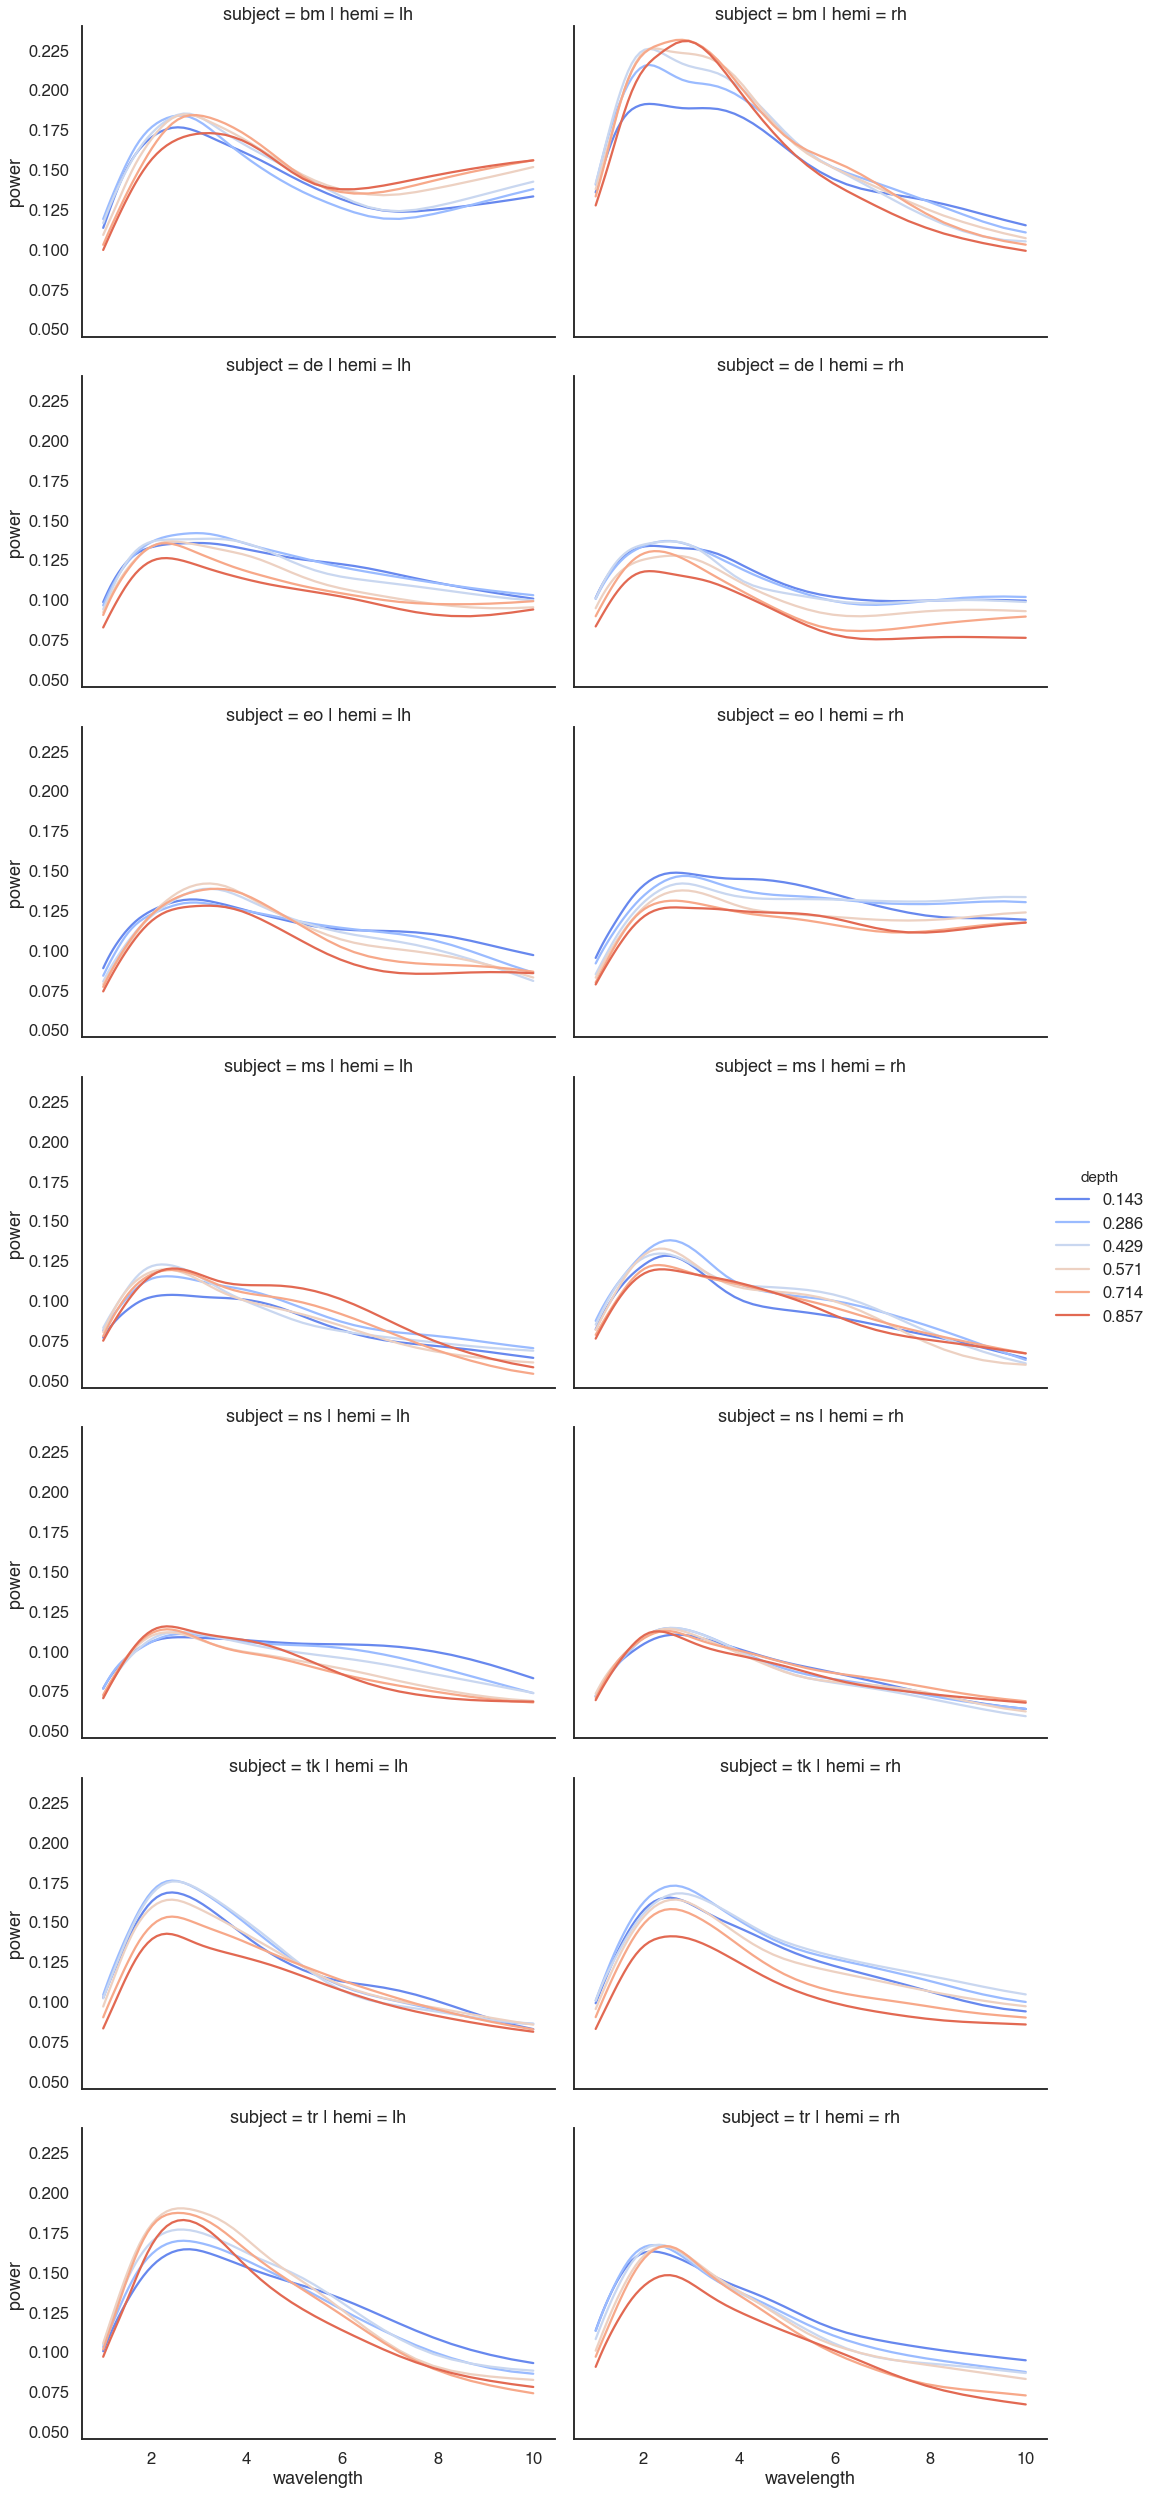

In [285]:
mean_wl_energie_across_orientations_incl_outliers = energies_incl_outliers.groupby(['depth', 'frequency']).mean()
power_incl_outliers = mean_wl_energie_across_orientations_incl_outliers.T.groupby(['subject', 'session', 'hemi']).mean().stack(['depth', 'frequency'])
power_incl_outliers = power_incl_outliers.to_frame('power').reset_index()
power_incl_outliers['wavelength'] = 1./power_incl_outliers['frequency']
fac = sns.FacetGrid(power_incl_outliers, hue='depth', aspect=1.5, palette='coolwarm', height=5., col='hemi', row='subject')
fac.map(sns.lineplot, 'wavelength', 'power', ci=None).add_legend()

In [286]:
modes_vertex_wise = power[power.wavelength < 8.].groupby(['subject', 'session', 'hemi', 'depth']).apply(lambda d: d.set_index('wavelength').power.argmax())

/Users/gdehol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


In [287]:
energies.apply(lambda d: d.argmax(), axis=0)

/Users/gdehol/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


subject        bm                                                              \
session       odc                                                               
hemi           rh                                                               
vertex     535       536       542       543       544       545       546      
0        0.857000  0.857000  0.714000  0.714000  0.429000  0.429000  0.429000   
1        0.790604  0.790604  0.308884  0.323746  0.355648  0.390694  0.429193   
2        2.356194  2.356194  2.552544  2.552544  2.945243  2.945243  0.000000   

subject                                ...        tr                      \
session                                ...       odc                       
hemi                                   ...        rh                       
vertex     554       555       556     ...    26951     26970     26986    
0        0.429000  0.286000  0.286000  ...  0.143000  0.143000  0.143000   
1        0.390694  0.517947  0.542868  ...  0.542868  0.568987  0.596362   
2        2.945243  2.945243  0.000000  ...  0.196350  0.196350  0.196350   

subject                                                                        
session                                                                        
hemi                                                                           
vertex     27006     366979    366980    366981    366982    367021    367022  
0        0.143000  0.143000  0.143000  0.714000  0.571000  0.714000  0.714000  
1        0.568987  0.294705  0.294705  0.449843  0.625055  0.471487  0.517947  
2        0.196350  0.000000  0.000000  0.392699  1.963495  0.589049  0.589049  

[3 rows x 46777 columns]

In [288]:
mode_frequency_per_vertex = energies.groupby(['depth', 'frequency']).sum().groupby(['depth'], as_index=True).apply(lambda d: d.reset_index('depth', drop=True).idxmax(0))

In [289]:
wl = mode_frequency_per_vertex.T.stack('depth').to_frame('main frequency').groupby(['subject', 'session', 'hemi', 'depth']).median()
wl['wavelength'] = 1./wl['main frequency']

In [290]:
sns.set_context('talk')

In [295]:
unique_subjects = power.subject.unique().tolist()
power['Subject'] = power['subject'].map(lambda d: 'Subject {}'.format(unique_subjects.index(d) + 1))
power['Power'] = power['power']

unique_depths = power.depth.unique().tolist()
power['Layer'] = power.depth.map(lambda d: 6 - unique_depths.index(d))

In [296]:
wl['Layer'] = wl.index.get_level_values('depth').map(lambda d: 6 - unique_depths.index(d)).astype(str)

In [320]:
sns.set(font_scale=2., style='white')

In [322]:
   from matplotlib.backends.backend_pdf import PdfPages


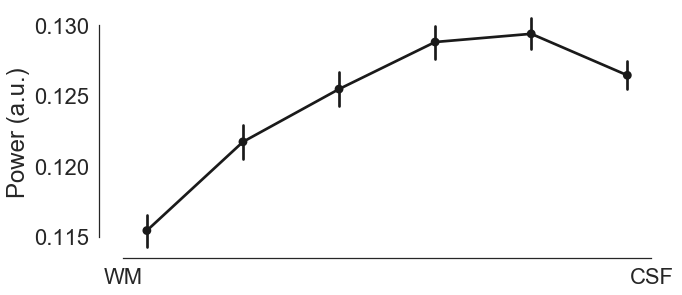

In [325]:
with PdfPages('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/known_patterns/depth_power.pdf') as pdf:

    fac = sns.catplot('Layer', 'power', data=power, kind='point', aspect=2., ci=67, color='k')
    fac.set_ylabels('Power (a.u.)')
    x_, _ = plt.xticks()
    plt.xticks([x_[0] - .25, x_[-1]+.25], ['WM', 'CSF'])
    sns.despine(trim=True)
    fac.set_xlabels('')
    # fac.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/known_patterns/depth_power.svg')

    pdf.savefig()

In [36]:
wl.groupby('depth').mean()

,main frequency,wavelength,Layer
depth,,,
0.143,0.379661,2.654932,6
0.286,0.376404,2.690773,5
0.429,0.370960,2.750622,4
0.571,0.374249,2.693886,3
0.714,0.370638,2.726753,2
0.857,0.369788,2.740679,1


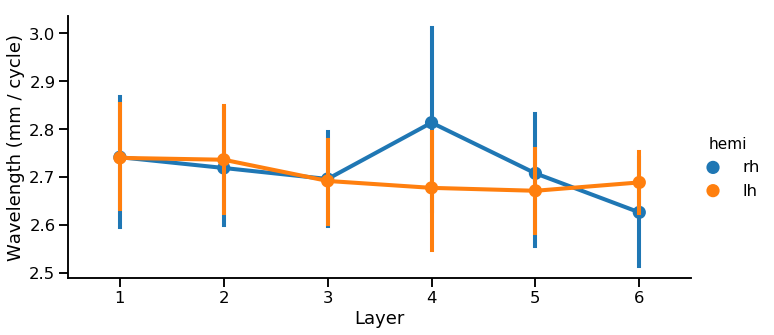

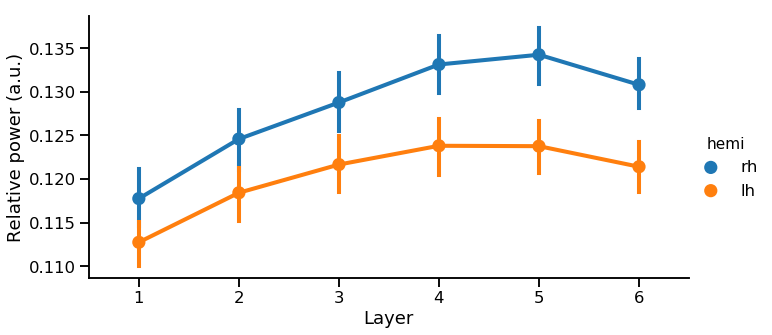

In [34]:
fac = sns.catplot('Layer', 'wavelength', hue='hemi', data=wl.reset_index(), kind='point', ci=67, aspect=2.)
fac.set_ylabels('Wavelength (mm / cycle)')

fac = sns.catplot('Layer', 'power', hue='hemi', data=power, kind='point', aspect=2.)
fac.set_ylabels('Relative power (a.u.)')

In [37]:
from statsmodels.stats.anova import AnovaRM


In [38]:
tmp = wl.reset_index()
tmp['subject_'] = tmp.apply(lambda row: '{subject}.{session}.{hemi}'.format(**row.to_dict()), axis=1)
r = AnovaRM(tmp, 'wavelength', 'subject_', ['depth']).fit()

r.summary()

,Num DF,Den DF,F Value,Pr > F
depth,5.0000,60.0000,0.7366,0.5989


In [44]:
tmp = power.reset_index()
tmp['subject_'] = tmp.apply(lambda row: '{subject}.{session}.{hemi}'.format(**row.to_dict()), axis=1)
r = AnovaRM(tmp.groupby(['subject_', "Layer"], as_index=False).mean(), 'power', 'subject_', ['Layer']).fit()

r.summary()

,Num DF,Den DF,F Value,Pr > F
Layer,5.0000,60.0000,14.3330,0.0000


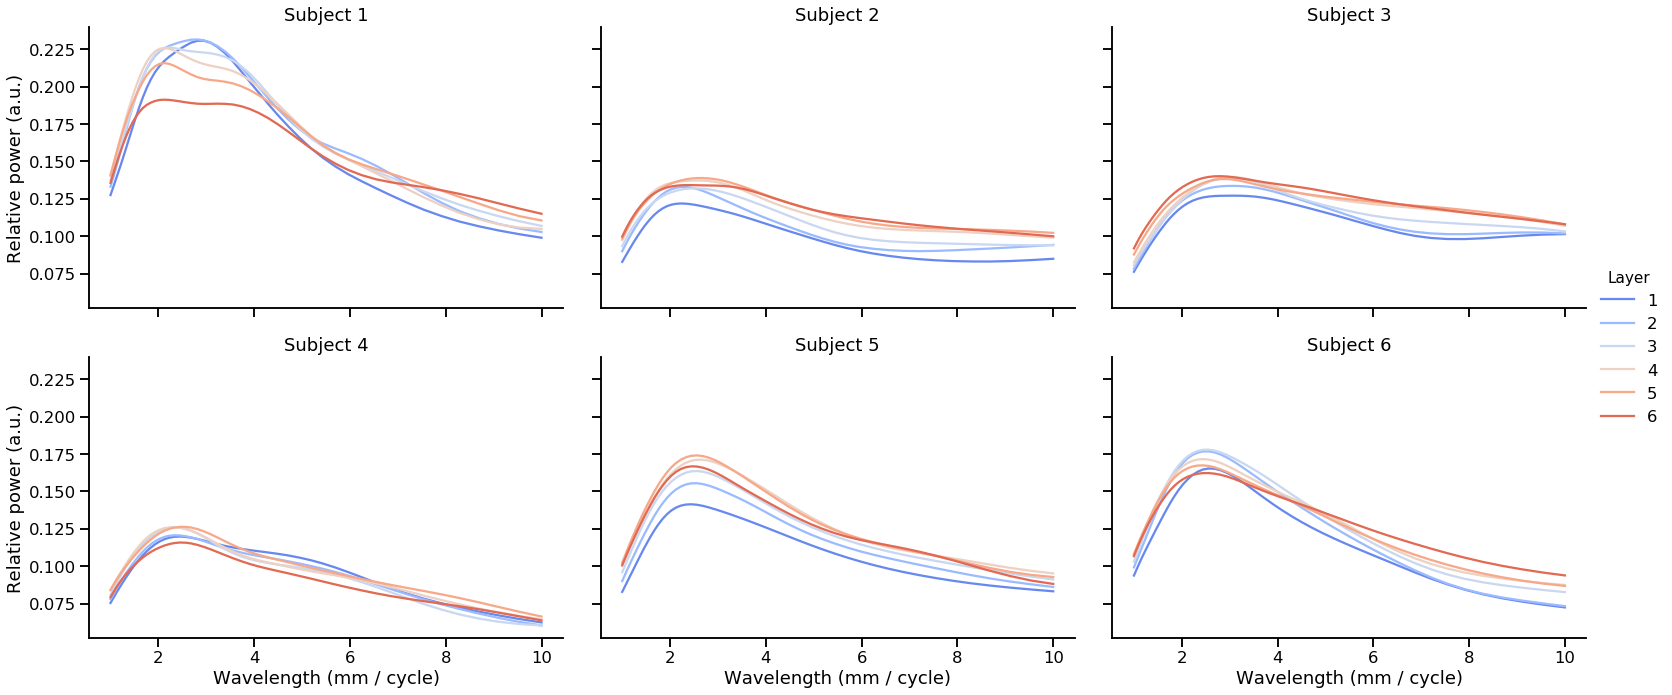

In [40]:
fac = sns.FacetGrid(power, hue='Layer', aspect=1.5, palette='coolwarm', height=5., col='Subject2', col_wrap=3.)
fac.map(sns.lineplot, 'wavelength', 'Power', ci=None).add_legend()
fac.set_titles('{col_name}')

fac.set_xlabels('Wavelength (mm / cycle)')
fac.set_ylabels('Relative power (a.u.)')

fac.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure5/sf_power_distributions.pdf')

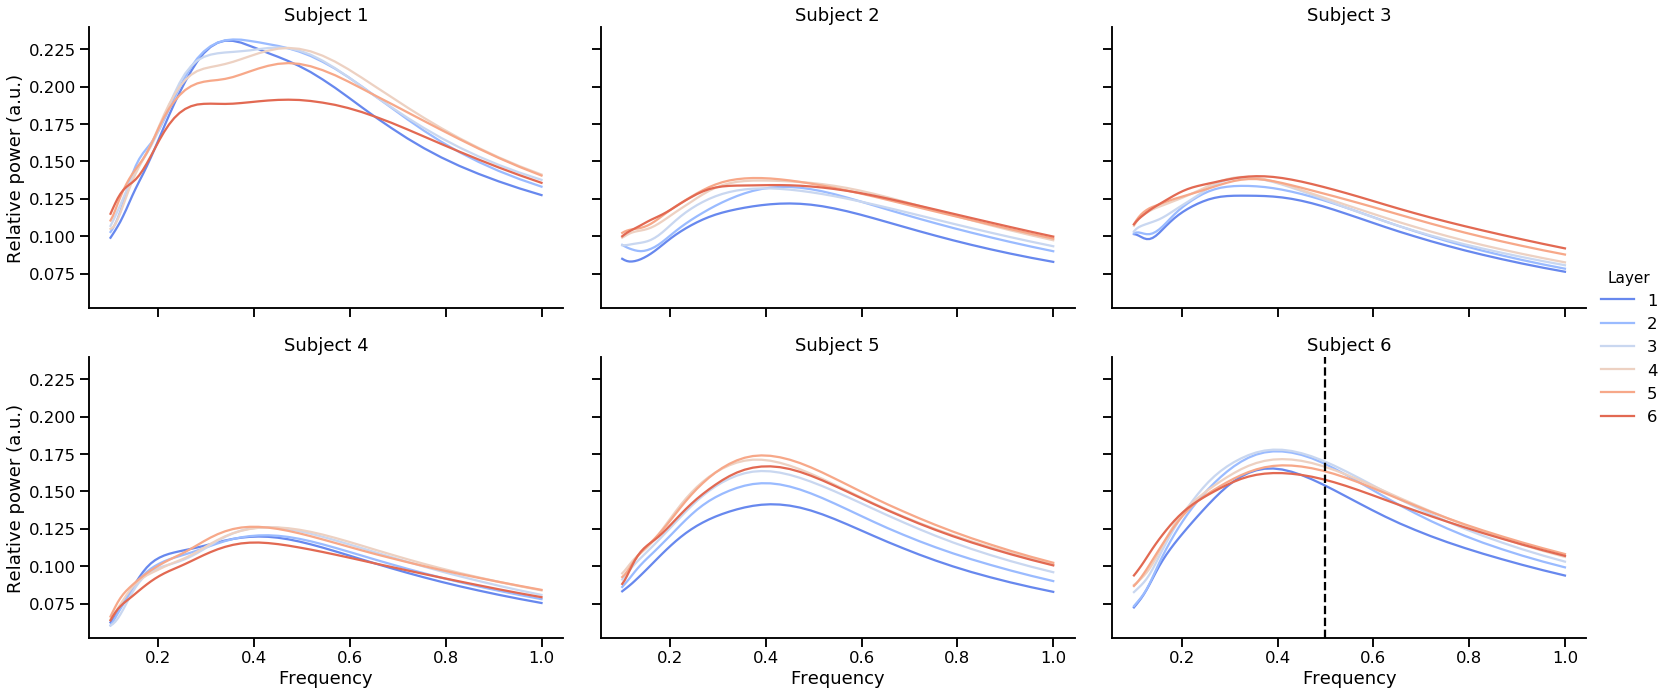

In [54]:
fac = sns.FacetGrid(power, hue='Layer', aspect=1.5, palette='coolwarm', height=5., col='Subject', col_wrap=3.)
fac.map(sns.lineplot, 'frequency', 'Power', ci=None).add_legend()
fac.set_titles('{col_name}')

fac.set_xlabels('Frequency')
fac.set_ylabels('Relative power (a.u.)')

plt.axvline(.5, c='k', ls='--')

# fac.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure5/sf_power_distributions.pdf')